In [1]:
!pip install torchtext==0.6.0

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data

from torchtext.data import Example, Dataset, Field

import spacy
import numpy as np

import time
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Cella 1 - Definizione dei campi e costruzione dei dataset

# Definizione dei campi
TEXT = data.Field(lower = True)  # Campo per il testo delle parole
UD_TAGS = data.Field(unk_token = None)  # Campo per i tag associati alle parole

# Funzione per la lettura dei dati da un file
def read_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        sentence = []
        for line in file:
            if line.strip() == '':
                if sentence:
                    data.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                text = parts[0]
                tag = parts[1]
                sentence.append((text, tag))
    return data

# Percorsi dei file per train, validation e test
train_path = '/content/drive/MyDrive/Colab Notebooks/trainU.txt'
valid_path = '/content/drive/MyDrive/Colab Notebooks/validU.txt'
test_path = '/content/drive/MyDrive/Colab Notebooks/testU.txt'

# Leggi i dati da tutti i file
train_data = read_data(train_path)
valid_data = read_data(valid_path)
test_data = read_data(test_path)

# Creazione degli oggetti Example per ogni set di dati
def create_examples(data):
    examples = []
    for sentence in data:
        words, tags = zip(*sentence)
        example = Example.fromlist([list(words), list(tags)], [('text', TEXT), ('udtags', UD_TAGS)])
        examples.append(example)
    return examples

# Creazione dei Dataset utilizzando gli Example
train_examples = create_examples(train_data)
valid_examples = create_examples(valid_data)
test_examples = create_examples(test_data)

train_data = Dataset(train_examples, [('text', TEXT), ('udtags', UD_TAGS)])
valid_data = Dataset(valid_examples, [('text', TEXT), ('udtags', UD_TAGS)])
test_data = Dataset(test_examples, [('text', TEXT), ('udtags', UD_TAGS)])


In [4]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")
print(vars(train_data[3718]))
print(vars(train_data.examples[0]))
print(vars(train_data.examples[0])['text'])
print(vars(train_data.examples[0])['udtags'])

Number of training examples: 13121
Number of validation examples: 564
Number of testing examples: 482
{'text': ['in', 'il', '1944', 'il', 'tribunale', 'di', 'roma', 'ordinò', 'la', 'confisca', 'totale', 'di', 'i', 'beni', 'di', 'la', 'famiglia', 'ciano', '.'], 'udtags': ['ADP', 'DET', 'NUM', 'DET', 'NOUN', 'ADP', 'PROPN', 'VERB', 'DET', 'NOUN', 'ADJ', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'PROPN', 'PUNCT']}
{'text': ['londra', '.'], 'udtags': ['PROPN', 'PUNCT']}
['londra', '.']
['PROPN', 'PUNCT']


**QUI CI VORREBBE IL CARICAMENTO DEL .vec**

In [12]:
#Cella 6 - Costruzione del vocabolario

MIN_FREQ = 1

TEXT.build_vocab(train_data,
                 min_freq = MIN_FREQ)


UD_TAGS.build_vocab(train_data)

In [13]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in UD_TAG vocabulary: {len(UD_TAGS.vocab)}")
print(TEXT.vocab.freqs.most_common(20))
print(UD_TAGS.vocab.itos)
print(UD_TAGS.vocab.freqs.most_common())

Unique tokens in TEXT vocabulary: 26276
Unique tokens in UD_TAG vocabulary: 18
[('di', 17628), (',', 11859), ('il', 11240), ('.', 9945), ('la', 8968), ('a', 6729), ('in', 6059), ('e', 5187), ('i', 4527), ("l'", 4347), ('le', 3975), ('che', 3647), ('è', 3392), ('da', 2946), ('per', 2716), ('"', 2457), ('un', 2347), ('si', 2203), ('?', 2163), ('non', 1768)]
['<pad>', 'NOUN', 'DET', 'ADP', 'PUNCT', 'VERB', 'ADJ', 'PROPN', 'AUX', 'ADV', 'PRON', 'CCONJ', 'NUM', 'SCONJ', 'X', 'SYM', 'INTJ', 'PART']
[('NOUN', 54983), ('DET', 45034), ('ADP', 41890), ('PUNCT', 31294), ('VERB', 23364), ('ADJ', 18322), ('PROPN', 13671), ('AUX', 10878), ('ADV', 10536), ('PRON', 10428), ('CCONJ', 7550), ('NUM', 4791), ('SCONJ', 2826), ('X', 272), ('SYM', 93), ('INTJ', 62), ('PART', 24)]


In [14]:
# Cella 8 - Definizione del metodo per il calcolo della percentuale di tag

def tag_percentage(tag_counts):
    # Calcola il conteggio totale di tutte le occorrenze delle etichette nel corpus fornito
    total_count = sum([count for tag, count in tag_counts])

    # Crea una lista di tuple che contengono l'etichetta, il suo conteggio e la percentuale di volte che l'etichetta compare rispetto al totale
    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]

    # Restituisce la lista delle tuple contenenti l'etichetta, il suo conteggio e la percentuale di frequenza rispetto al conteggio totale
    return tag_counts_percentages

print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(UD_TAGS.vocab.freqs.most_common()):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

NOUN		54983		19.9%
DET		45034		16.3%
ADP		41890		15.2%
PUNCT		31294		11.3%
VERB		23364		 8.5%
ADJ		18322		 6.6%
PROPN		13671		 5.0%
AUX		10878		 3.9%
ADV		10536		 3.8%
PRON		10428		 3.8%
CCONJ		7550		 2.7%
NUM		4791		 1.7%
SCONJ		2826		 1.0%
X		272		 0.1%
SYM		93		 0.0%
INTJ		62		 0.0%
PART		24		 0.0%


In [15]:
# Cella 9 - Definizione dei BatchIterator

# Imposta la dimensione del batch per il training e il testing
BATCH_SIZE = 128

# Verifica se è disponibile una GPU (CUDA); se sì, utilizza la GPU altrimenti la CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Crea iteratori per il training, la validazione e il testing
# Si utilizza data.BucketIterator.splits per creare iteratori suddivisi in batch
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    # I dataset utilizzati per il training, la validazione e il testing
    (train_data, valid_data, test_data),

    # Imposta la dimensione di ogni batch
    batch_size=BATCH_SIZE,

    # Specifica una chiave di ordinamento basata sulla lunghezza del campo 'text'
    sort_key=lambda x: len(x.text),

    # Indica se ordinare all'interno di ogni batch (False indica di non farlo)
    sort_within_batch=False,

    # Indica il dispositivo su cui caricare i dati (CPU o GPU)
    device=device
)

In [16]:
# Cella 10 - Definizione del modello BiLSTM

class BiLSTMPOSTagger(nn.Module):
    def __init__(self,
                 input_dim,       # Dimensione dell'input (vocabolario o numero di token unici)
                 embedding_dim,   # Dimensione dell'embedding per i token
                 hidden_dim,      # Dimensione degli hidden states nella LSTM
                 output_dim,      # Dimensione dell'output (numero di etichette POS)
                 n_layers,        # Numero di layer LSTM impilati
                 bidirectional,   # Flag per indicare se la LSTM è bidirezionale
                 dropout,         # Valore dropout per evitare l'overfitting
                 pad_idx):        # Indice del token di padding nella sequenza

        super().__init__()

        # Layer di embedding per mappare gli indici dei token in spazi di embedding
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        # Strato LSTM che riceve gli embeddings come input
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            dropout=dropout if n_layers > 1 else 0)

        # Strato fully-connected per produrre l'output con le etichette POS
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout layer per evitare l'overfitting durante l'addestramento
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [lunghezza frase, dimensione batch]

        # Passaggio degli input attraverso il layer di embedding
        embedded = self.dropout(self.embedding(text))

        # embedded = [lunghezza frase, dimensione batch, dimensione embedding]

        # Passaggio degli embeddings nella rete LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        # outputs contiene gli hidden states sia per la direzione forward che backward
        # hidden e cell rappresentano gli hidden states e cell states all'ultimo timestep

        # predictions = [lunghezza frase, dimensione batch, dimensione output]
        predictions = self.fc(self.dropout(outputs))

        return predictions


In [31]:
# Cella 11 - Creazione di un modello BiLSTM

# Ottieni la dimensione dell'input dal vocabolario dei token
INPUT_DIM = len(TEXT.vocab)

# Dimensione degli embedding per i token (es. parole)
EMBEDDING_DIM = 100

# Dimensione degli hidden states nella LSTM
HIDDEN_DIM = 128

# Ottieni la dimensione dell'output dal vocabolario delle etichette di parte del discorso
OUTPUT_DIM = len(UD_TAGS.vocab)

# Numero di layer LSTM impilati
N_LAYERS = 2

# Indica se la LSTM è bidirezionale
BIDIRECTIONAL = True

# Valore dropout per evitare l'overfitting durante l'addestramento
DROPOUT = 0.25

# Ottieni l'indice del token di padding (PAD) dal vocabolario dei token
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Crea un'istanza del modello BiLSTMPOSTagger con i parametri definiti sopra
model = BiLSTMPOSTagger(INPUT_DIM,
                        EMBEDDING_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT,
                        PAD_IDX)


In [32]:
# Cella 12 - Inizializzazione dei parametri

def init_weights(m):
    # Itera su tutti i parametri (pesi) del modello m
    for name, param in m.named_parameters():
        # Inizializza i pesi utilizzando una distribuzione normale con media 0 e deviazione standard 0.1
        nn.init.normal_(param.data, mean=0, std=0.1)

# Applica la funzione init_weights al modello, inizializzando i suoi pesi
model.apply(init_weights)

BiLSTMPOSTagger(
  (embedding): Embedding(26276, 100, padding_idx=1)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [33]:
# Cella 13 - Stampa del numero di parametri addestrabili del modello

def count_parameters(model):
    # Conta il numero totale di parametri addestrabili nel modello
    # Usando una comprehensions su tutti i parametri addestrabili
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Stampa il numero di parametri addestrabili nel modello utilizzando la funzione count_parameters
print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,263,010 trainable parameters


In [34]:
# Cella 14 - Stampa dei vettori di parole preaddestrati del vocabolario TEXT.vocab

#pretrained_embeddings = TEXT.vocab.vectors

#print(pretrained_embeddings.shape)

In [ ]:
# Cella 15 - Inizializzazione del layer di embedding con i vettori preaddestrati

#model.embedding.weight.data.copy_(pretrained_embeddings)

In [35]:
# Cella 16 - Inizializzazione del token di padding con un vettore di zeri

model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[-0.1227, -0.1049,  0.0090,  ..., -0.0864, -0.0029, -0.0396],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1810,  0.1585, -0.0993,  ...,  0.0354,  0.1524,  0.0711],
        ...,
        [-0.0827,  0.0332, -0.1810,  ...,  0.0090,  0.1574, -0.0553],
        [-0.0652, -0.3150,  0.0571,  ...,  0.2043, -0.0863,  0.0169],
        [-0.0139,  0.0227, -0.1934,  ...,  0.0447, -0.2378, -0.0632]])


In [36]:
# Cella 17 - Definizione dell'ottimizzatore

optimizer = optim.Adam(model.parameters())

In [37]:
# Cella 18 - Ignora i tag di padding durante il calcolo della loss

TAG_PAD_IDX = UD_TAGS.vocab.stoi[UD_TAGS.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [38]:
# Cella 19 - Sposta tutto su device (GPU o CPU)

model = model.to(device)
criterion = criterion.to(device)

In [39]:
# Cella 20 - Definizione della funzione di calcolo dell'accuratezza

def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [40]:
def precision(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim=1, keepdim=True)
    non_pad_elements = (y != tag_pad_idx).nonzero()
    true_positives = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]).sum().item()
    false_positives = (max_preds.squeeze(1) != y).sum().item() - true_positives
    precision = true_positives / (true_positives + false_positives)
    return precision if (true_positives + false_positives) > 0 else 0

def recall(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim=1, keepdim=True)
    non_pad_elements = (y != tag_pad_idx).nonzero()
    true_positives = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements]).sum().item()
    false_negatives = (y[non_pad_elements].shape[0]) - true_positives
    recall = true_positives / (true_positives + false_negatives)
    return recall if (true_positives + false_negatives) > 0 else 0


In [41]:
# Cella 21 - Definizione della funzione di addestramento

def train(model, iterator, optimizer, criterion, tag_pad_idx):
    # Inizializzazione delle variabili per la perdita e l'accuratezza sull'intero epoch
    epoch_loss = 0
    epoch_acc = 0

    # Imposta il modello in modalità di addestramento
    model.train()

    # Ciclo attraverso i batch nel dataset di addestramento
    for batch in iterator:
        # Estrazione del testo e delle etichette POS dal batch corrente
        text = batch.text
        tags = batch.udtags

        # Azzeramento dei gradienti del modello
        optimizer.zero_grad()

        # Esecuzione del modello sul testo per ottenere le previsioni
        predictions = model(text)

        # Riformattazione delle previsioni e delle etichette per il calcolo della perdita
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        # Calcolo della perdita utilizzando il criterio di perdita
        loss = criterion(predictions, tags)

        # Calcolo dell'accuratezza utilizzando la funzione categorical_accuracy
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)

        # Passaggio di backward e ottimizzazione dei pesi del modello
        loss.backward()
        optimizer.step()

        # Aggiornamento della somma cumulativa della perdita e dell'accuratezza per questo epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # Calcolo della perdita media e dell'accuratezza media per l'intero epoch
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [42]:
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import torch

def evaluate(model, iterator, criterion, tag_pad_idx, UD_TAGS):
    epoch_loss = 0
    epoch_acc = 0

    tag_errors = defaultdict(int)
    tag_totals = defaultdict(int)

    all_predictions = []
    all_tags = []

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            tags = batch.udtags

            predictions = model(text)
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            top_predictions = predictions.argmax(-1)
            for pred_tag, true_tag in zip(top_predictions.cpu().numpy(), tags.cpu().numpy()):
                tag_totals[UD_TAGS.vocab.itos[true_tag]] += 1
                if pred_tag != true_tag:
                    tag_errors[UD_TAGS.vocab.itos[true_tag]] += 1

            all_predictions.extend(top_predictions.cpu().numpy())
            all_tags.extend(tags.cpu().numpy())

    avg_loss = epoch_loss / len(iterator)
    avg_acc = epoch_acc / len(iterator)

    tag_error_percentages = {
        tag: (tag_errors[tag] / tag_totals[tag]) * 100 if tag_totals[tag] != 0 else 0
        for tag in tag_totals
    }

    sorted_tag_errors = sorted(tag_error_percentages.items(), key=lambda x: x[1], reverse=True)

    confusion_mat = confusion_matrix(all_tags, all_predictions, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

    precision = precision_score(all_tags, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_tags, all_predictions, average='weighted', zero_division=0)

    return avg_loss, avg_acc, sorted_tag_errors, all_tags, all_predictions, confusion_mat, precision, recall


In [43]:
# Cella 22 - Definizione della funzione di calcolo del tempo tra due istanti

def epoch_time(start_time, end_time):
    # Calcolo del tempo trascorso tra l'inizio e la fine dell'epoch
    elapsed_time = end_time - start_time

    # Conversione del tempo trascorso in minuti e secondi
    elapsed_mins = int(elapsed_time / 60)  # Ottiene i minuti arrotondati all'intero più vicino
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))  # Ottiene i secondi rimanenti dopo aver sottratto i minuti

    # Restituzione del tempo trascorso in minuti e secondi
    return elapsed_mins, elapsed_secs


In [44]:
N_EPOCHS = 10  # Numero di epoch da eseguire
best_valid_loss = float('inf')  # Inizializzazione della migliore perdita su dati di validazione

for epoch in range(N_EPOCHS):  # Ciclo attraverso gli epoch definiti

    start_time = time.time()  # Registra il tempo di inizio dell'epoch

    # Addestramento del modello sul dataset di addestramento
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)

    # Valutazione del modello sul dataset di validazione
    valid_loss, valid_acc, tag_errors, all_tags, all_predictions, conf_matrix, precision, recall = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX, UD_TAGS)

    end_time = time.time()  # Registra il tempo di fine dell'epoch

    # Calcola la durata dell'epoch
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Aggiorna i pesi del modello se la perdita sul dataset di validazione è migliorata
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/bilstm.pt')  # Salva i pesi del modello

    # Stampa le informazioni sull'epoch corrente (perdita e accuratezza di addestramento e validazione)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.421 | Train Acc: 54.94%
	 Val. Loss: 0.546 |  Val. Acc: 82.61%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.373 | Train Acc: 88.35%
	 Val. Loss: 0.266 |  Val. Acc: 91.75%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.202 | Train Acc: 93.92%
	 Val. Loss: 0.219 |  Val. Acc: 93.25%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.138 | Train Acc: 95.95%
	 Val. Loss: 0.205 |  Val. Acc: 93.90%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.106 | Train Acc: 96.88%
	 Val. Loss: 0.194 |  Val. Acc: 94.11%
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.087 | Train Acc: 97.43%
	 Val. Loss: 0.204 |  Val. Acc: 94.16%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.074 | Train Acc: 97.80%
	 Val. Loss: 0.193 |  Val. Acc: 94.54%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.065 | Train Acc: 98.02%
	 Val. Loss: 0.202 |  Val. Acc: 94.64%
Epoch: 09 | Epoch Time: 0m 3s
	Train Loss: 0.057 | Train Acc: 98.23%
	 Val. Loss: 0.219 |  Val. Acc: 94.38%
Epoch: 10 | Epoch Time: 0m 3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tag: NOUN | Precision: 95.93% | Recall: 94.40%
Tag: DET | Precision: 99.07% | Recall: 99.42%
Tag: ADP | Precision: 99.27% | Recall: 99.09%
Tag: PUNCT | Precision: 100.00% | Recall: 99.91%
Tag: VERB | Precision: 93.87% | Recall: 88.64%
Tag: ADJ | Precision: 76.33% | Recall: 90.59%
Tag: PROPN | Precision: 87.01% | Recall: 83.56%
Tag: AUX | Precision: 95.87% | Recall: 97.53%
Tag: ADV | Precision: 94.21% | Recall: 93.27%
Tag: PRON | Precision: 96.52% | Recall: 94.40%
Tag: CCONJ | Precision: 100.00% | Recall: 100.00%
Tag: NUM | Precision: 98.66% | Recall: 85.96%
Tag: SCONJ | Precision: 84.40% | Recall: 92.00%
Tag: X | Precision: 0.00% | Recall: 0.00%
Tag: SYM | Precision: 100.00% | Recall: 100.00%
Tag: INTJ | Precision: 0.00% | Recall: 0.00%
Tag: PART | Precision: 0.00% | Recall: 0.00%
Tag: NOUN | F1 Score: 95.15%
Tag: DET | F1 Score: 99.24%
Tag: ADP | F1 Score: 99.18%
Tag: PUNCT | F1 Score: 99.96%
Tag: VERB | F1 Score: 91.18%
Tag: ADJ | F1 Score: 82.85%
Tag: PROPN | F1 Score: 85.25%
Tag: A

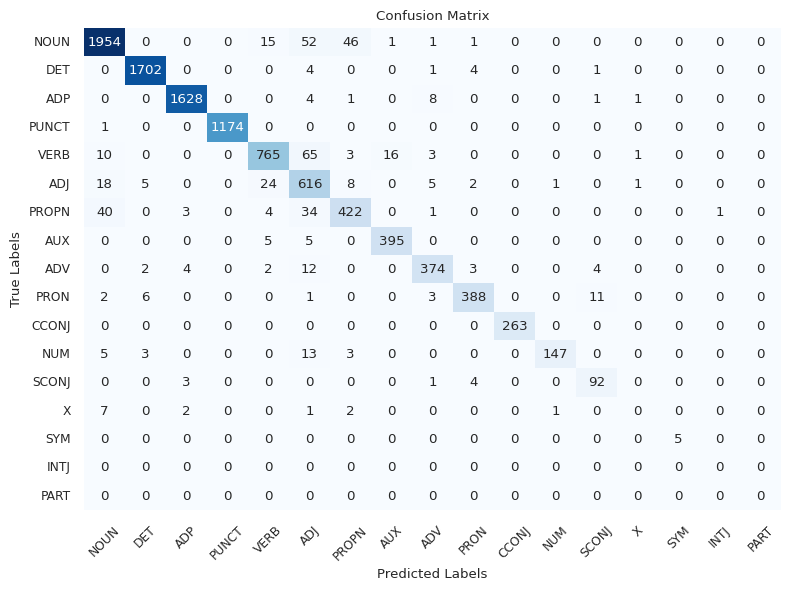

In [45]:
# Cella 24 - Valutazione del modello sul test set

import matplotlib.pyplot as plt
import seaborn as sns

# Carica i pesi salvati del modello dal file 'bilstm-model.pt'
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/bilstm.pt'))

# Valuta le prestazioni del modello sul dataset di test
test_loss, test_acc, tag_errors, all_tags, all_predictions, conf_matrix, precision, recall = evaluate(model, test_iterator, criterion, TAG_PAD_IDX, UD_TAGS)

# Calcola la matrice di confusione utilizzando sklearn
conf_matrix = confusion_matrix(all_tags, all_predictions, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

# Rimuovi le predizioni relative al tag '<pad>' da all_tags e all_predictions
all_tags_filtered = [tag for tag in all_tags if UD_TAGS.vocab.itos[tag] != '<pad>']
all_predictions_filtered = [pred for idx, pred in enumerate(all_predictions) if UD_TAGS.vocab.itos[all_tags[idx]] != '<pad>']

# Calcolo della precisione, del richiamo e dell'accuratezza per ogni classe
precisions = precision_score(all_tags_filtered, all_predictions_filtered, average=None, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])
recalls = recall_score(all_tags_filtered, all_predictions_filtered, average=None, labels=[tag_idx for tag_idx in range(len(UD_TAGS.vocab.itos)) if UD_TAGS.vocab.itos[tag_idx] != '<pad>'])

# Stampa della precisione, del richiamo e dell'accuratezza per ogni classe
for tag, precision, recall in zip([tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'], precisions, recalls):
    print(f'Tag: {tag} | Precision: {precision*100:.2f}% | Recall: {recall*100:.2f}%')

# Calcolo della F1 score per ogni classe
f1_scores = []
for precision, recall in zip(precisions, recalls):
    if precision == 0 and recall == 0:
        f1_scores.append(0)  # Se sia la precisione che il richiamo sono nulli, la F1 sarà 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

# Stampare i valori F1 in percentuale per ogni classe
for tag, f1_score in zip([tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'], f1_scores):
    f1_percent = f1_score * 100
    print(f'Tag: {tag} | F1 Score: {f1_percent:.2f}%')



# Calcolo dell'accuratezza per ogni classe
class_accuracy = {}
for tag_idx in range(len(UD_TAGS.vocab.itos)):
    tag = UD_TAGS.vocab.itos[tag_idx]
    if tag != '<pad>':
        correct_indices = [i for i, (true, pred) in enumerate(zip(all_tags, all_predictions)) if true == tag_idx and pred == true]
        total_instances = len([true for true in all_tags if true == tag_idx])
        class_acc = len(correct_indices) / total_instances if total_instances != 0 else 0
        class_accuracy[tag] = class_acc

# Stampa dell'accuratezza per ogni classe
for tag, acc in class_accuracy.items():
    print(f'Tag: {tag} | Accuracy: {acc*100:.2f}%')

# Stampa la perdita e l'accuratezza calcolate sul dataset di test
print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')
print(tag_errors)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.set(font_scale=0.8)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=[tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'],
            yticklabels=[tag for tag in UD_TAGS.vocab.itos if tag != '<pad>'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Cella 25 - Definizione di una funzione per il tagging di una frase

def tag_sentence(model, device, sentence, text_field, tag_field):
    # Imposta il modello in modalità di valutazione
    model.eval()

    # Tokenizzazione della frase di input
    if isinstance(sentence, str):
        # Se la frase è una stringa, utilizza Spacy per ottenere i token
        nlp = spacy.load('en_core_web_sm')
        tokens = [token.text for token in nlp(sentence)]
    else:
        # Se la frase è già tokenizzata, usa direttamente i token forniti
        tokens = [token for token in sentence]

    # Se necessario, converte i token in minuscolo
    if text_field.lower:
        tokens = [t.lower() for t in tokens]

    # Numericalizzazione dei token utilizzando il vocabolario del campo di testo
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    # Ottiene l'indice per i token "sconosciuti" (UNK)
    unk_idx = text_field.vocab.stoi[text_field.unk_token]

    # Identifica i token "sconosciuti" nella frase di input
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]

    # Converte i token numerici in un tensore PyTorch
    token_tensor = torch.LongTensor(numericalized_tokens)

    # Modifica la forma del tensore per il modello e sposta i dati sulla GPU, se disponibile
    token_tensor = token_tensor.unsqueeze(-1).to(device)

    # Esegue il modello per ottenere le predizioni
    predictions = model(token_tensor)

    # Ottiene le predizioni con la massima probabilità per ciascun token
    top_predictions = predictions.argmax(-1)

    # Converte gli indici predetti in etichette POS utilizzando il vocabolario delle etichette
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]

    # Restituisce i token della frase, le relative etichette predette e i token "sconosciuti"
    return tokens, predicted_tags, unks


In [ ]:
example_index = 1  # Indice dell'esempio da esaminare nel set di dati di addestramento

# Ottiene la frase e le etichette POS effettive dall'esempio nel set di dati di addestramento
sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['udtags']

print(sentence)  # Stampa la frase dell'esempio


['gas', 'da', 'la', 'statua', '.']


In [ ]:
# Esegue la funzione 'tag_sentence' per ottenere i token della frase, le etichette POS predette e i token "sconosciuti".
tokens, pred_tags, unks = tag_sentence(model, device, sentence, TEXT, UD_TAGS)

# Stampa i token "sconosciuti" trovati nella frase, ovvero i token non identificati durante il tagging POS.
print(unks)

[]


In [ ]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")
# Stampa un'intestazione per il confronto, indicando le colonne per le etichette POS predette, effettive, la correttezza e i token.

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    # Itera attraverso i token della frase, le relative etichette POS predette ed effettive utilizzando la funzione zip().

    correct = '✔' if pred_tag == actual_tag else '✘'
    # Verifica se l'etichetta POS predetta coincide con l'etichetta POS effettiva per il token attuale.
    # Se coincidono, imposta la variabile 'correct' a '✔', altrimenti a '✘'.

    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")
    # Stampa le etichette POS predette, effettive, la correttezza e i token corrispondenti alla riga attuale.


Pred. Tag	Actual Tag	Correct?	Token

NOUN		NOUN		✔		gas
ADP		ADP		✔		da
DET		DET		✔		la
NOUN		NOUN		✔		statua
PUNCT		PUNCT		✔		.


In [ ]:
sentence = 'Bologna è una città universitaria molto affascinante. È famosa per i suoi portici e per la sua cucina deliziosa. Le torri rappresentano un punto centrale e storico della città.'
# Definisce una frase da analizzare.

tokens, tags, unks = tag_sentence(model, device, sentence, TEXT, UD_TAGS)
# Esegue la funzione 'tag_sentence' per ottenere i token della frase, le etichette POS predette e i token "sconosciuti".

print(unks)
# Stampa i token "sconosciuti" trovati nella frase, ovvero i token non identificati durante il tagging POS.


['portici', 'deliziosa', 'della']


In [ ]:
print("Pred. Tag\tToken\n")
# Stampa un'intestazione per indicare le colonne delle etichette predette e dei token.

for token, tag in zip(tokens, tags):
    # Itera attraverso ciascun token e l'etichetta predetta, utilizzando la funzione zip() per accoppiare i valori.

    print(f"{tag}\t\t{token}")
    # Stampa l'etichetta predetta e il token corrispondente nella frase attuale.


Pred. Tag	Token

PROPN		bologna
AUX		è
DET		una
NOUN		città
ADJ		universitaria
ADV		molto
ADJ		affascinante
PUNCT		.
AUX		è
ADJ		famosa
ADP		per
DET		i
DET		suoi
NOUN		portici
CCONJ		e
ADP		per
DET		la
DET		sua
NOUN		cucina
VERB		deliziosa
PUNCT		.
DET		le
NOUN		torri
VERB		rappresentano
DET		un
NOUN		punto
ADJ		centrale
CCONJ		e
ADJ		storico
VERB		della
NOUN		città
PUNCT		.
